# 4.1 Solving Sudoku using Grover's Algorithm

## Introduction

The oracles used throughout this chapter so far have been created with **prior knowledge** of their solutions. We will now solve a simple problem using Grover's algorithm, for which we **do not necessarily know the solution beforehand**.

Our problem is a **2×2 binary sudoku**, which has two simple rules:

1. No column may contain the same value twice
2. No row may contain the same value twice

If we assign each square in our sudoku to a variable:

```
┌────┬────┐
│ v0 │ v1 │   ← top row
├────┼────┤
│ v2 │ v3 │   ← bottom row
└────┴────┘
```

We want our circuit to output a solution to this sudoku.


## Setting Up the Problem

Since we need to check down both columns and across both rows, there are **4 conditions** we need to check:

```
v0 ≠ v1   # check along top row
v2 ≠ v3   # check along bottom row
v0 ≠ v2   # check down left column
v1 ≠ v3   # check down right column
```

In [1]:
from Helper_Functions import Sudoku_oracle, Grover_operator, Get_Data_from_Fake_backend
import numpy as np
import math

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime.fake_provider import FakeAlgiers
from qiskit.visualization import plot_distribution


## Define the Clause List and Registers

We compile our set of comparisons into a list of clauses:

In [2]:
clause_list = [[0, 1],   # v0 ≠ v1 (top row)
               [0, 2],   # v0 ≠ v2 (left column)
               [1, 3],   # v1 ≠ v3 (right column)
               [2, 3]]   # v2 ≠ v3 (bottom row)

var_qubits = QuantumRegister(4, name='v')       # 4 variable qubits (v0, v1, v2, v3)
clause_qubits = QuantumRegister(4, name='c')    # 4 clause-checking qubits
output_qubit = QuantumRegister(1, name='out')   # 1 output qubit
cbits = ClassicalRegister(4, name='cbits')      # 4 classical bits for measurement

## The Sudoku Oracle
The oracle checks all 4 conditions using XOR gates. If **all** conditions are satisfied, it flips the output qubit.

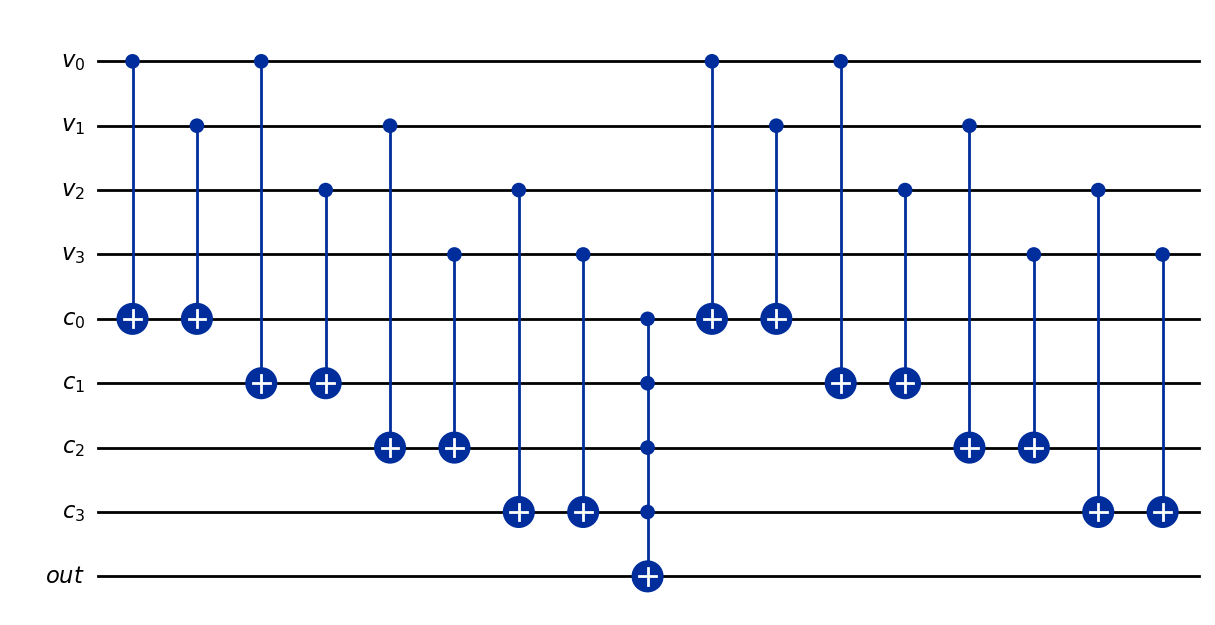

In [3]:
oracle = Sudoku_oracle(var_qubits, clause_list, clause_qubits, output_qubit)
oracle.draw(output="mpl", style="iqp")

## Grover Operator

Using the oracle we just created, we can now build the Grover operator. We apply the reflection to all **4 variable qubits** only (not the clause or output qubits).

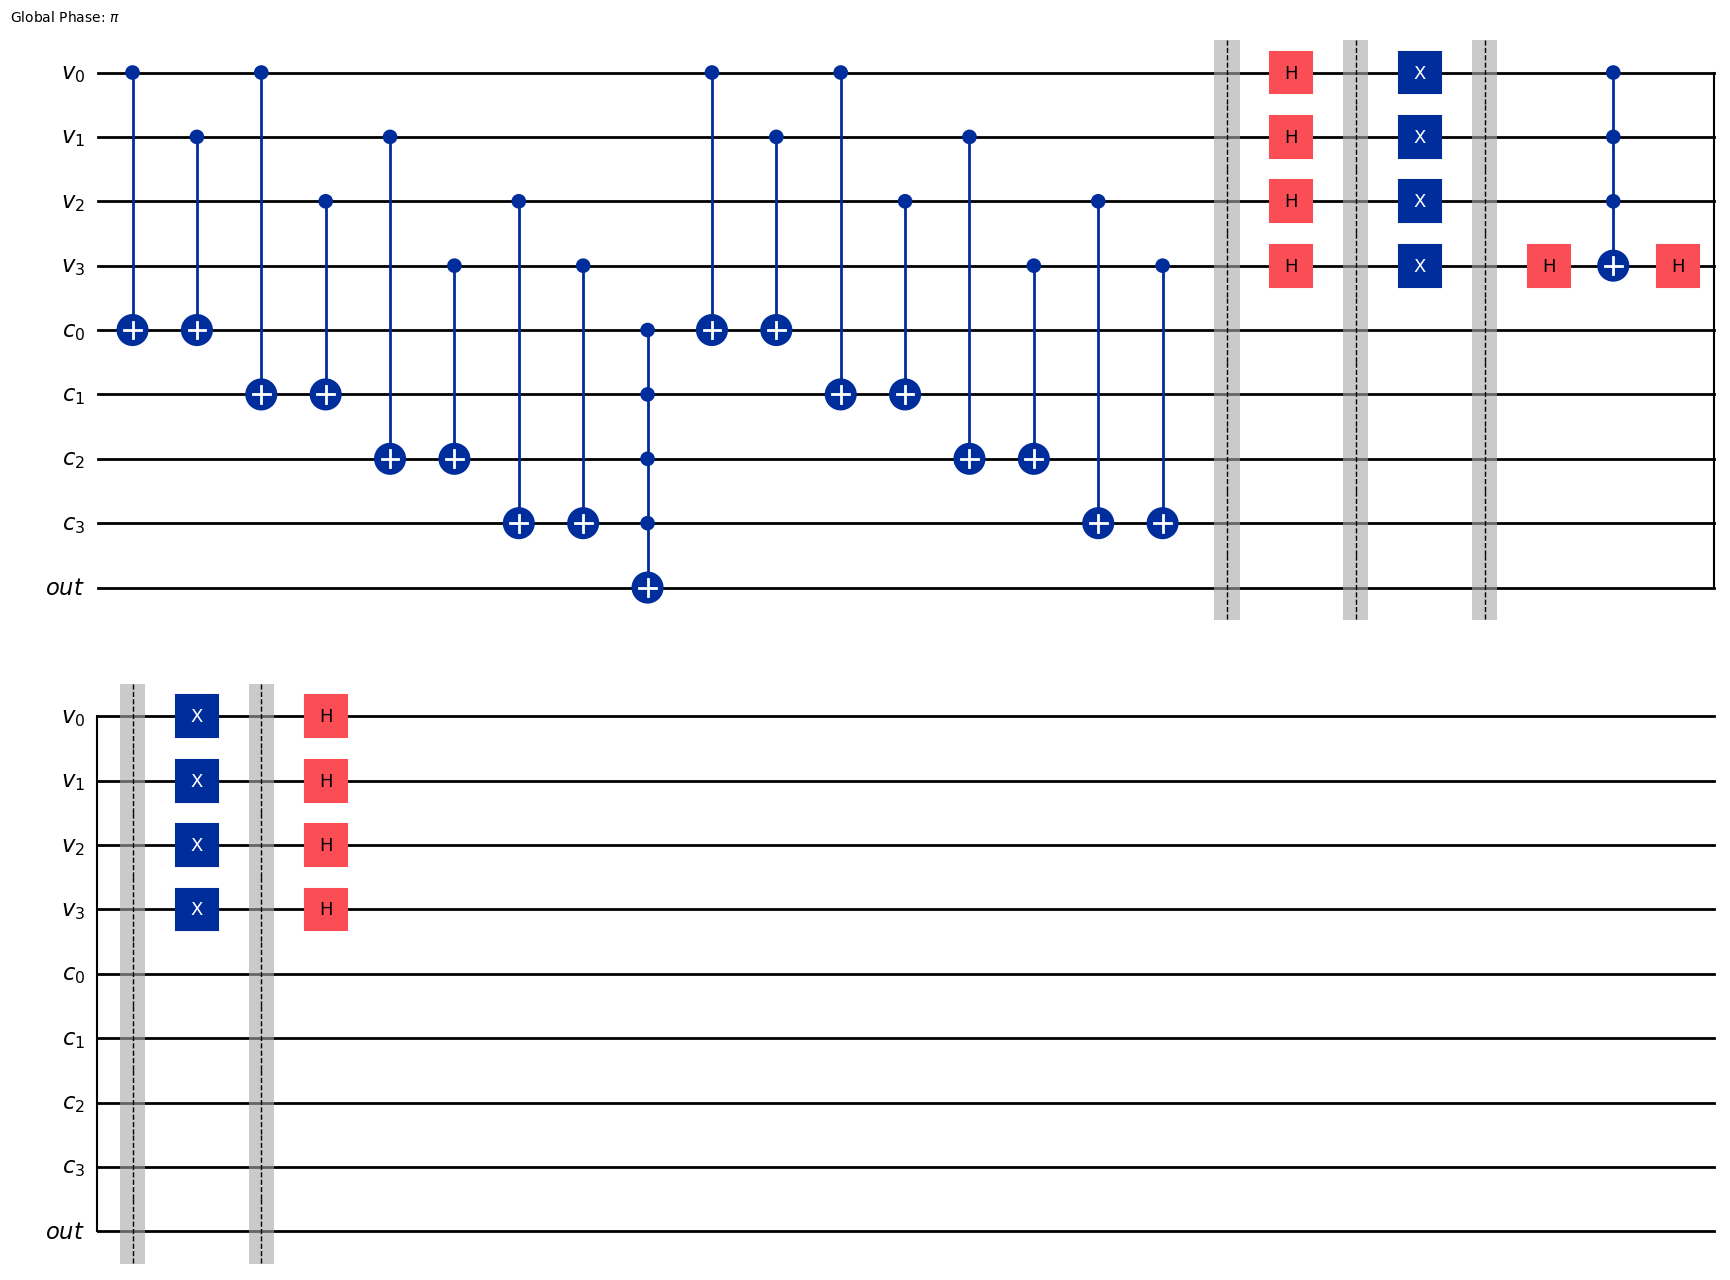

In [4]:
Grover_op = Grover_operator(oracle, insert_barriers=True, name="Grover Op",
                            reflection_qubits=[var_qubits[0], var_qubits[1],
                                               var_qubits[2], var_qubits[3]])
Grover_op.draw(output="mpl", style="iqp")

## Building the Grover Circuit

In [5]:
iterations = 1
Grover_circuit = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out' qubit in state |-> (minus state)
# This trick converts phase flips from the oracle into amplitude changes
Grover_circuit.initialize([1, -1] / np.sqrt(2), output_qubit)

### Step 1: Apply Hadamard gates to the variable qubits to create a superposition

In [6]:
Grover_circuit.h(var_qubits)

### Step 2: Apply the Grover operator the specified number of iterations

In [7]:
for _ in range(iterations):
    Grover_circuit.compose(Grover_op, inplace=True)

### Step 3: Measure the variable qubits

In [8]:
Grover_circuit.measure(var_qubits, cbits)

### Draw the complete circuit

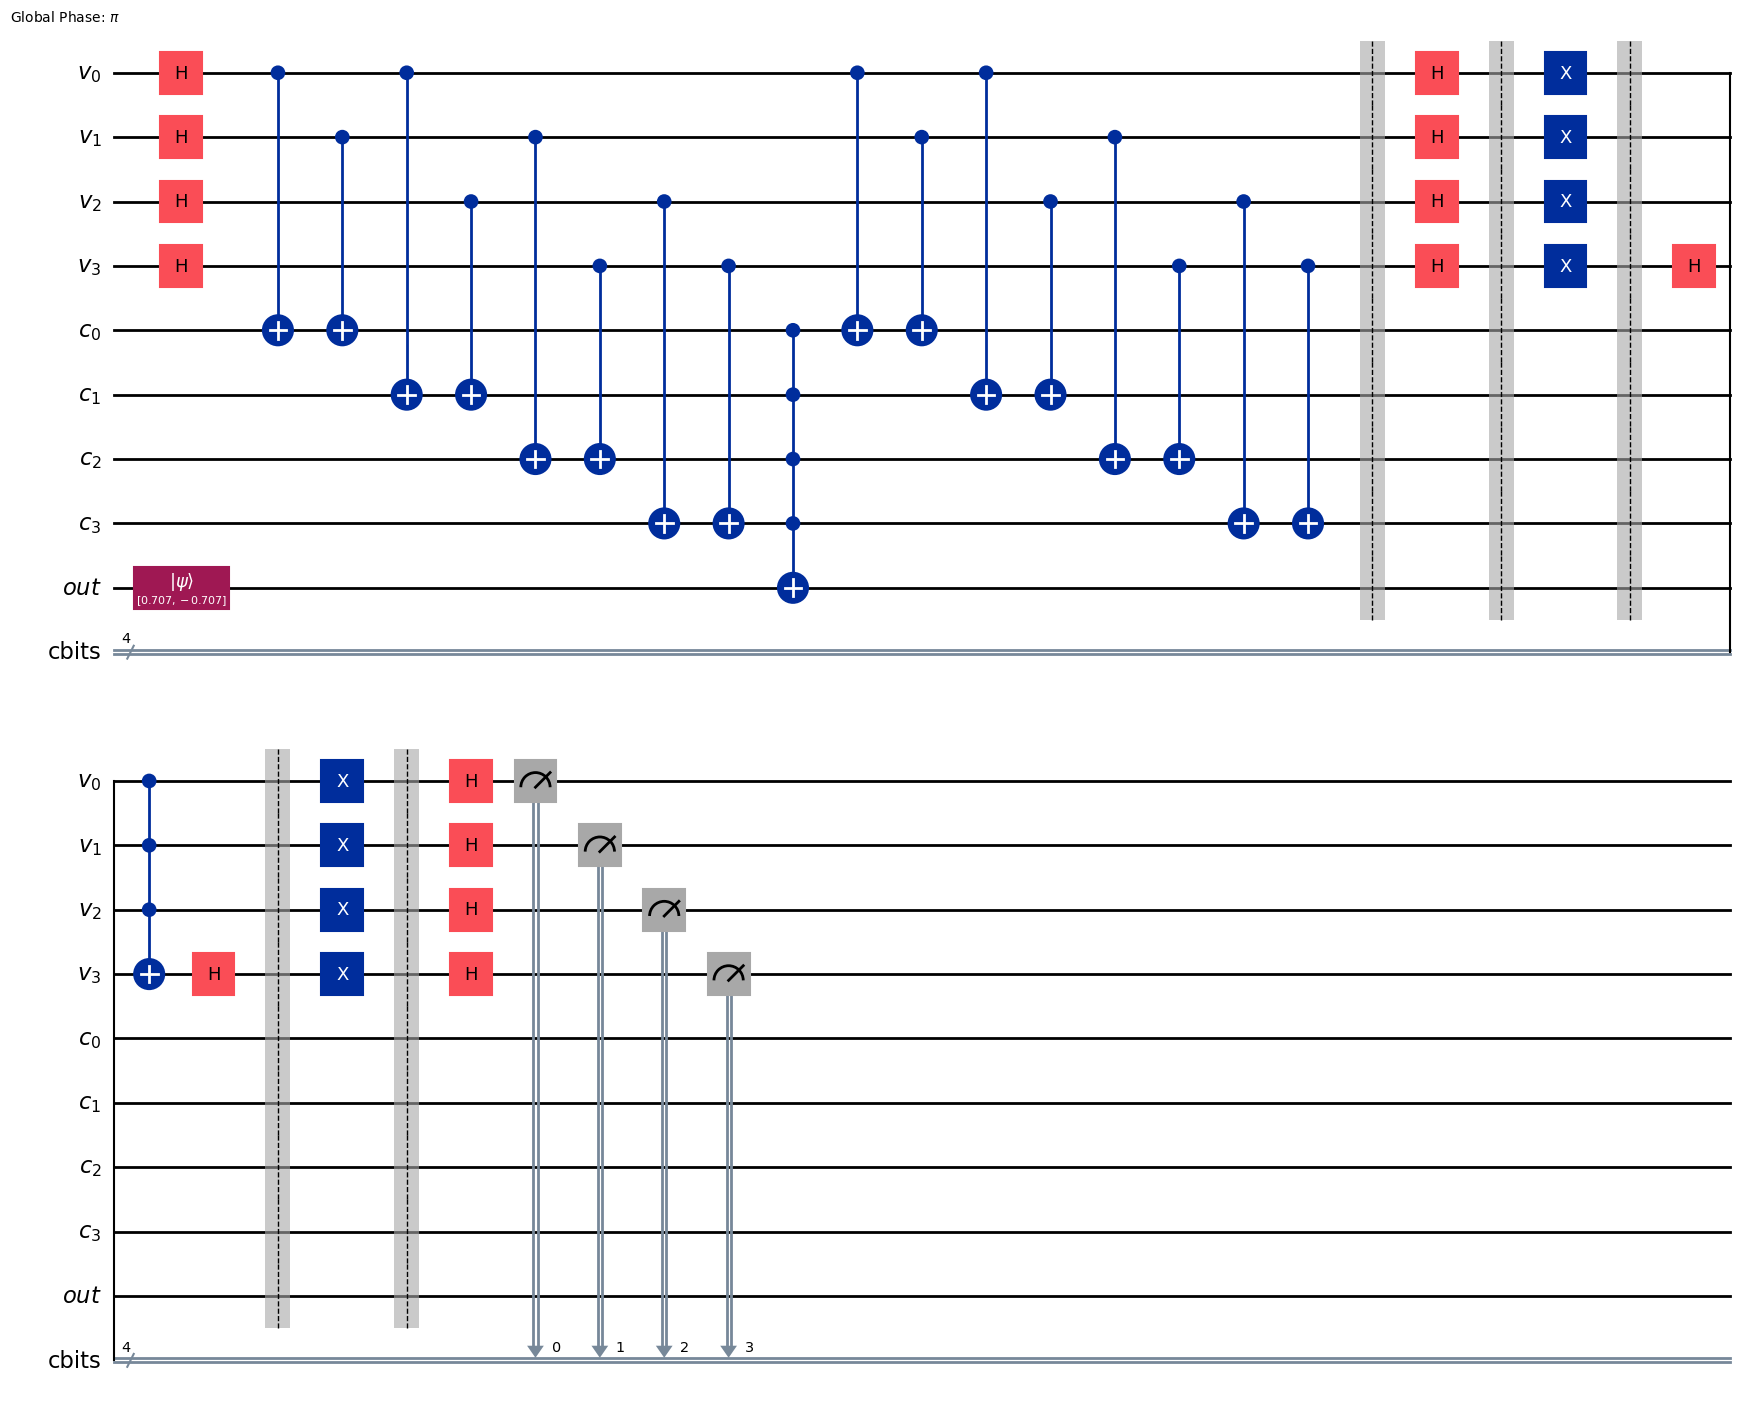

In [9]:
Grover_circuit.draw(output="mpl", style="iqp")

## Step 4: Simulate using StatevectorSampler (Ideal — no noise)

We first run an ideal simulation to check that the amplitude of the solution states is indeed amplified.

Ideal simulation results:
{'1110': 71, '0101': 74, '0001': 85, '0110': 1915, '1001': 1983, '0100': 75, '1011': 95, '1100': 62, '1010': 85, '0010': 81, '0000': 83, '0011': 83, '1111': 74, '0111': 75, '1101': 76, '1000': 83}


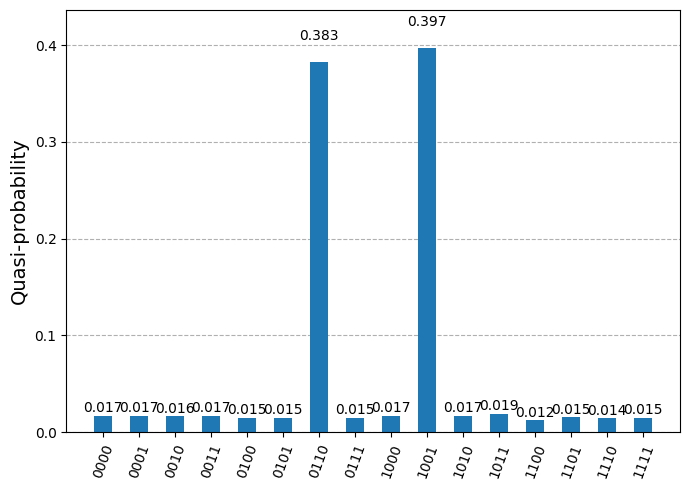

In [10]:
sampler = StatevectorSampler()

# Run using sampler
result = sampler.run([Grover_circuit], shots=5000).result()

# Access result data for PUB 0 and plot distribution
data_pub = result[0].data
counts_ideal = data_pub.cbits.get_counts()
print("Ideal simulation results:")
print(counts_ideal)
plot_distribution(counts_ideal)

## Step 5: Run the circuit on the fake backend and plot the results

+ Now we run on `FakeAlgiers` to see how noise affects the results.

Noisy simulation results:
{'0110': 1317, '0101': 520, '1011': 515, '0010': 630, '0000': 532, '1001': 1313, '1101': 530, '1111': 444, '1000': 563, '1110': 491, '0100': 529, '1100': 525, '0111': 502, '0001': 529, '0011': 492, '1010': 568}


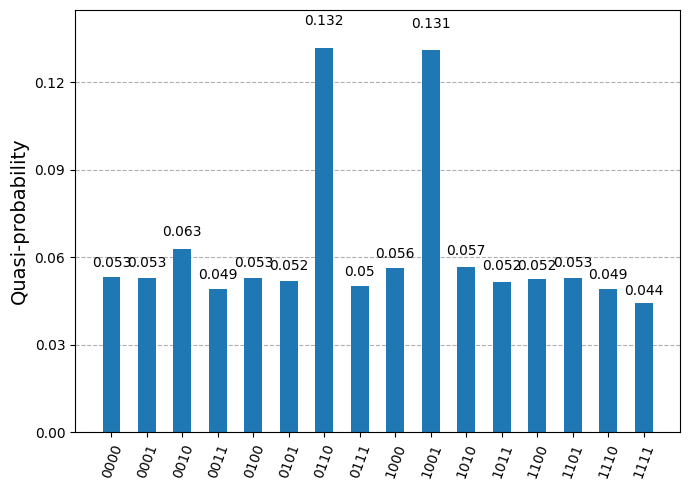

In [11]:
data = Get_Data_from_Fake_backend(10000, Grover_circuit, FakeAlgiers())

counts_noisy = data.cbits.get_counts()
print("Noisy simulation results:")
print(counts_noisy)
plot_distribution(counts_noisy)

## Results and Interpretatio

There are **two bit strings** with a much higher probability of measurement than any of the others: **`0110`** and **`1001`**.

These correspond to the two solutions of our 2×2 binary sudoku:

### Solution 1: `0110`

```
v0 = 0, v1 = 1, v2 = 1, v3 = 0

┌───┬───┐
│ 0 │ 1 │   ← top row: 0 ≠ 1 ✅
├───┼───┤
│ 1 │ 0 │   ← bottom row: 1 ≠ 0 ✅
└───┴───┘
  ↑   ↑
  0≠1 1≠0
  ✅   ✅
```

### Solution 2: `1001`

```
v0 = 1, v1 = 0, v2 = 0, v3 = 1

┌───┬───┐
│ 1 │ 0 │   ← top row: 1 ≠ 0 ✅
├───┼───┤
│ 0 │ 1 │   ← bottom row: 0 ≠ 1 ✅
└───┴───┘
  ↑   ↑
  1≠0 0≠1
  ✅   ✅
```

Both solutions satisfy **all 4 rules** — no repeated values in any row or column!

---

## Key Takeaways

1. **No prior knowledge needed:** Unlike previous exercises, we didn't tell the oracle what the answer was. The oracle only encodes the **rules** of the puzzle, and Grover's algorithm **discovers** the solutions.

2. **Multiple solutions found simultaneously:** The algorithm found **both** valid solutions in a single run.

3. **Only 1 iteration needed:** With 2 solutions out of 16 states (M/N = 1/8), just 1 Grover iteration is enough to strongly amplify the correct answers.

4. **Real-world application:** This same approach scales to larger constraint satisfaction problems — SAT solvers, graph coloring, scheduling, and more!